In [ ]:
'''
1.BP神经网络
见 'MPLClassifier.ipynb'

2.RBF神经网络
RBF神经网络经过这样两层变化: $\left\{\begin{array}{l}R_i(X)=exp(-||X-C_i||^2/2\sigma_i^2),\qquad i=1,\cdots,m\\\hat{y}_k=\sum\limits_{i=1}^{m}\omega_{ik}R_i(X),\qquad k=1,\cdots,p\end{array}\right.$
这样只有小部分靠近中心的隐藏层神经元被激活($R_i(X)$随着其中范数增大,指数减少)
确定基函数中心$C_i$. 一般采用K均值聚类法.
确定基函数宽度$\sigma_i$. 通常令它等于基函数中心与子样本集中样本模式之间的平均距离
确定权值$\omega_{ik}$. 采用最小均方误差测度.
'''

In [2]:
# RBF神经网络(based on tensorflow): https://github.com/shiluqiang/RBF_NN_tensorflow/blob/master/RBF_tensorflow.py
# 由于数据量小, 本人的不熟悉等原因, 预测结果并不理想.

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
import pandas as pd
from sklearn import preprocessing

class RBF_NN():
    def __init__(self, hidden_nodes, input_data_trainX, input_data_trainY):
        self.hidden_nodes = hidden_nodes #隐含层节点数
        self.input_data_trainX = input_data_trainX #训练样本的特征
        self.input_data_trainY = input_data_trainY #训练样本的标签
    
    def fit(self):
        '''模型训练
        '''
        tf.compat.v1.disable_eager_execution()
        # 1.声明输入输出的占位符
        n = 19
        n_input = (self.input_data_trainX).shape[1]
        n_output = (self.input_data_trainY).shape[0]
        X = tf.compat.v1.placeholder('float', [None, n_input],name = 'X')
        Y = tf.compat.v1.placeholder('float', [None, 1],name = 'Y')
        
        # 2.参数设置
        ## RBF函数参数
        ### K-means求中心
        random_state = 170
        kms = KMeans(n_clusters=self.hidden_nodes, random_state=None)
        pred = kms.fit_predict(trainX)
        
        # c = tf.Variable(tf.random_normal(shape=(self.hidden_nodes, n_input)),name = 'c')
        # c = tf.concat((tf.cast(tf.Variable(kms.cluster_centers_), tf.float32), c), axis=0)
        c = tf.cast(tf.Variable(kms.cluster_centers_), tf.float32)
        delta = tf.Variable(tf.compat.v1.random_normal(shape=(1,self.hidden_nodes)), name='delta')
        ## 隐含层到输出层权重和偏置
        W = tf.Variable(tf.compat.v1.random_normal(shape=(self.hidden_nodes, 1)), name='W')
        b = tf.Variable(tf.compat.v1.random_normal(shape=(1, 1)), name='b')
        
        # 3.构造前向传播计算图
        ## 隐含层输出
        ### 特征样本与RBF均值的距离
        dist = tf.reduce_sum(tf.square(tf.subtract(tf.tile(X,[self.hidden_nodes, 1]),c)), axis=1)
        dist = tf.multiply(1.0,tf.transpose(dist))
        ### RBF方差的平方
        delta_2 = tf.square(delta)
        ### 隐含层输出
        RBF_OUT = tf.exp(tf.multiply(-1.0,tf.divide(dist,tf.multiply(2.0,delta_2))))
        ## 输出层输入
        output_in = tf.matmul(RBF_OUT, W) + b
        
        # 4.声明代价函数优化算法
        loss = tf.reduce_mean(tf.pow(Y - output_in,2)) #损失函数为均方误差
        train_op = tf.compat.v1.train.AdamOptimizer(0.1).minimize(loss) #优化算法为梯度下降法
    
        # 5.反向传播求参数
        trX = self.input_data_trainX[:n]
        trY = self.input_data_trainY[:n]
        
        with tf.compat.v1.Session() as sess:
            ## 初始化所有参数
            tf.compat.v1.global_variables_initializer().run()
            for epoch in range(200):
                for i in range(trX.shape[0]):
                    feed = {X:trX[i][:,None].T, Y:[[trY[i]]]}
                    sess.run(train_op,feed_dict=feed)
                if epoch % 20. == 0 :
                    total_loss = 0.0
                    for j in range(trX.shape[0]):
                        total_loss += sess.run(loss, feed_dict={X:trX[i][:,None].T, Y:[[trY[i]]]})
                    print('Loss function at step %d is %s'%(epoch, total_loss / trX.shape[0]))
                    
            print('Training complete!')

            W = W.eval()
            b = b.eval()
            c = c.eval()
            delta = delta.eval()
            pred_trX = np.mat(np.zeros((len(trX),n_output)))
            
            ## 训练准确率
            correct_tr = 0.0
            pred = []
            for i in range(self.input_data_trainX.shape[0]):
                pred_tr = sess.run(output_in, feed_dict={X:self.input_data_trainX[i][:,None].T})
                pred.append(pred_tr[0][0])
            df_columns = ['Input', 'Pred Out', 'Raw Out', 'Error', 'Relative Error']
            pred = np.array(pred)
            df = pd.DataFrame(np.c_[[x.__str__() for x in self.input_data_trainX],
                                    pred,
                                    self.input_data_trainY,
                                    np.subtract(pred, self.input_data_trainY),
                                    np.array(np.divide(np.subtract(pred, self.input_data_trainY), self.input_data_trainY), dtype=np.float)
                                   ], columns=df_columns)
            print('Relative Error Sum: {:.4%}'.format(df['Relative Error'].astype(float).abs().sum()))
            df['Pred Out'] = df['Pred Out'].apply(lambda x: format(float(x), '.4f'))
            df['Raw Out'] = df['Raw Out'].apply(lambda x: format(float(x), '.1f'))
            df['Error'] = df['Error'].apply(lambda x: format(float(x), '.4f'))
            df['Relative Error'] = df['Relative Error'].apply(lambda x: format(float(x), '.4%'))
            print(df)

data = np.loadtxt('15.D 水库年径流与因子特征.txt')
# data = preprocessing.scale(data)

trainX = data[:, :-1]
trainY = data[:, -1]
input_data_trainX = trainX
input_data_trainY = trainY
rbf = RBF_NN(10, input_data_trainX, input_data_trainY)
rbf.fit()


ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
# MLPClassifier（多层感知器分类器）
# 官方文档说明书: https://scikit-learn.org/stable/modules/neural_networks_supervised.html
# 相关公式推导: https://blog.csdn.net/xholes/article/details/78461164

# INTRODUCTION:
# 不能支持GPU
# 只支持交叉熵损失函数("Currently, MLPClassifier supports only the Cross-Entropy loss function")
# 使用softmax函数来表现预测结果概率.要得到概率,可调用"predict_proba"函数
# 支持一样例多标签的分类
# 参数alpha用以正则化(L2 regularization),来惩罚权重.
# scale化.均值变1,方差变0
# 热启动与监控
import pprint
import warnings

In [4]:
# 官方示例
from sklearn.neural_network import MLPClassifier
X = [[0., 0.], [1., 1.]]
y = [0, 1]
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
clf.fit(X, y)
MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1, solver='lbfgs')

print('权重矩阵:\n', clf.coefs_, sep='')
print('权重矩阵大小: ', [coef.shape for coef in clf.coefs_], sep='')
print('偏置b:\n', clf.intercepts_, sep='')
print('偏置b大小: ', [intercept.shape for intercept in clf.intercepts_], sep='')

print('预测结果:')
print(clf.predict([[2., 2.], [-1., -2.]]))
print(clf.predict_proba([[2., 2.], [-1., -2.]]))

权重矩阵:
[array([[-0.14196276, -0.02104562, -0.85522848, -3.51355396, -0.60434709],
       [-0.69744683, -0.9347486 , -0.26422217, -3.35199017,  0.06640954]]), array([[ 0.29164405, -0.14147894],
       [ 2.39665167, -0.6152434 ],
       [-0.51650256,  0.51452834],
       [ 4.0186541 , -0.31920293],
       [ 0.32903482,  0.64394475]]), array([[-4.53025854],
       [-0.86285329]])]
权重矩阵大小: [(2, 5), (5, 2), (2, 1)]
偏置b:
[array([-0.14962269,  0.75950271, -0.5472481 ,  6.92417703, -0.87510813]), array([-0.47635084, -0.76834882]), array([8.53354251])]
偏置b大小: [(5,), (2,), (1,)]
预测结果:
[1 0]
[[1.96718015e-004 9.99803282e-001]
 [1.00000000e+000 4.67017947e-144]]


In [5]:
# 支持一样例多标签的分类的示例:
X = [[0., 0.], [1., 1.]]
y = [[0, 1], [1, 1]]
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15,), random_state=1)
clf.fit(X, y)
print(clf.predict_proba([[1., 2.]]), 'predicted as: ', clf.predict([[1., 2.]]))
print(clf.predict_proba([[0., 0.]]), 'predicted as: ', clf.predict([[0., 0.]]))

[[0.99999999 1.        ]] predicted as:  [[1 1]]
[[7.67594868e-05 9.99992280e-01]] predicted as:  [[0 1]]


In [10]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.neural_network import MLPClassifier

# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X / 255.

# rescale the data, use the traditional train/test split
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=10, alpha=1e-4,
                    solver='sgd', verbose=10, random_state=1,
                    learning_rate_init=.1)

mlp.fit(X_train, y_train)
print("Training set score: %f" % mlp.score(X_train, y_train))
print("Test set score: %f" % mlp.score(X_test, y_test))

fig, axes = plt.subplots(4, 4)
# use global min / max to ensure all weights are shown on the same scale
vmin, vmax = mlp.coefs_[0].min(), mlp.coefs_[0].max()
for coef, ax in zip(mlp.coefs_[0].T, axes.ravel()):
    ax.matshow(coef.reshape(28, 28), cmap=plt.cm.gray, vmin=.5 * vmin,
               vmax=.5 * vmax)
    ax.set_xticks(())
    ax.set_yticks(())

plt.show()

KeyboardInterrupt: 

D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the nu

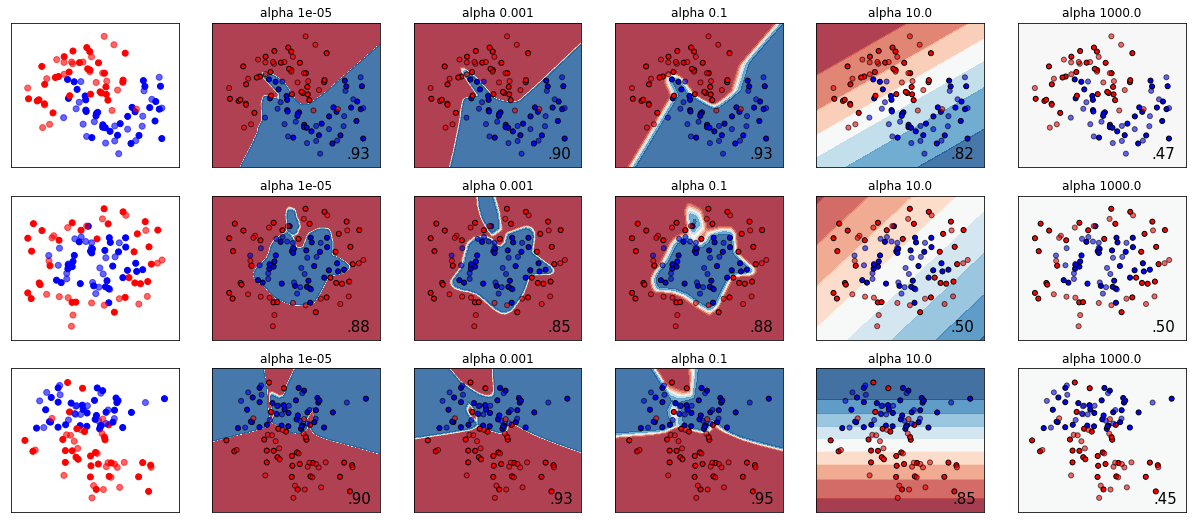

In [7]:
# 正则化惩罚

# Author: Issam H. Laradji
# License: BSD 3 clause

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier

h = .02  # step size in the mesh

alphas = np.logspace(-5, 3, 5)
names = ['alpha ' + str(i) for i in alphas]

classifiers = []
for i in alphas:
    classifiers.append(MLPClassifier(solver='lbfgs', alpha=i, random_state=1,
                                     hidden_layer_sizes=[100, 100]))

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=0, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable]

figure = plt.figure(figsize=(17, 9))
i = 1
# iterate over datasets
for X, y in datasets:
    # preprocess dataset, split into training and test part
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot also the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='black', s=25)
        # and testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   alpha=0.6, edgecolors='black', s=25)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

figure.subplots_adjust(left=.02, right=.98)
plt.show()


In [ ]:
# 标准化数据. 均值变成0,方差变成1
# Scale的方法有: Minmaxscaler, robustscaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Don't cheat - fit only on training data
scaler.fit(X_train)
X_train = scaler.transform(X_train)
# apply same transformation to test data
X_test = scaler.transform(X_test)

In [11]:
# 热启动与监控
X = [[0., 0.], [1., 1.]]
y = [0, 1]
# 通过max_iter=1, warm_start=True实现
clf = MLPClassifier(hidden_layer_sizes=(15,), random_state=1, max_iter=1, warm_start=True)
for i in range(10):
    clf.fit(X, y)
    print(clf.predict_proba([[-1., -2.]]))
    # additional monitoring / inspection

[[0.91340593 0.08659407]]
[[0.91342877 0.08657123]]
[[0.9134515 0.0865485]]
[[0.91358443 0.08641557]]
[[0.91360717 0.08639283]]
[[0.91374055 0.08625945]]
[[0.91376332 0.08623668]]
[[0.91389361 0.08610639]]
[[0.91391278 0.08608722]]
[[0.91404705 0.08595295]]


D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
